# Preparation

<b>Load Libraries</b>

In [1]:
# data structures
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
## settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# models selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

# metrics
from sklearn.metrics import fbeta_score, make_scorer, classification_report

# pipeline
from imblearn.pipeline import Pipeline

# compose
from sklearn.compose import ColumnTransformer

# preprocessings
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# features selection
from mlxtend.feature_selection import SequentialFeatureSelector

# resamplings
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# algorithms
## linear_model
from sklearn.linear_model import LogisticRegression
## neighbors
from sklearn.neighbors import KNeighborsClassifier
## svm
from sklearn.svm import SVC
## tree
from sklearn.tree import DecisionTreeClassifier
## ensample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# others
import re

<b>Load Dataset</b>

In [2]:
# dataset
df_base = pd.read_csv('../../../dataset/cleaned/train.csv')
df_base['area_code'] = df_base['area_code'].astype(str)

## 
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()[0:-1]

##
num_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_base.columns.tolist()) if name in cat_cols]

<b>User-Defined Functions</b>

In [3]:
# parsed names:
def get_parsed_names(old_names: list, new_names: list) -> list:
    parsed_names = []

    for name in new_names:
        eles = [ele for ele in re.split('_', name) if ele != '']
        eles[1] = int(re.split('x', eles[1])[-1])

        if name != 'remainder':
            parsed_names.append(
                f'{old_names[eles[1]]}_{eles[-1]}'
            )
        else:
            parsed_names.append(f'{old_names[eles[1]]}')

    return parsed_names

In [4]:
# train-test split
def get_train_test_split(df: pd.DataFrame) -> tuple[np.array: float, np.array: float, np.array: float, np.array: float, list]:
    arr = df.copy().values
    X, y =  arr[:, :-1], arr[:, -1]

    ## le
    le = LabelEncoder()
    y = le.fit_transform(y)

    ## ohe
    ohe = [('ohe', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)]
    ct = ColumnTransformer(
        transformers=ohe, remainder='passthrough', 
        n_jobs=-1
    )
    X = ct.fit_transform(X)\
        .astype(float)
    
    # parsed names
    parsed_names = get_parsed_names(
        old_names=df.columns.tolist(),
        new_names=ct.get_feature_names_out()
    )
    
    ##
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    return X_train, X_test, y_train, y_test, parsed_names

In [5]:
X_train, X_test, y_train, y_test, parsed_names = get_train_test_split(df=df_base)

In [6]:
# models
def load_base_models() -> list:
    models = []
    models.append(('LR', LogisticRegression(n_jobs=-1)))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('SVC', SVC()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1)))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGBM', LGBMClassifier(verbose=-1, n_jobs=-1)))
    models.append(('XGB', XGBClassifier(n_jobs=-1)))

    return models 

In [7]:
# kflold result
def get_kfold_result(models: list, X: np.array, y: np.array) -> tuple[np.array, np.array]:
    ##
    names, results = [], []
    cv = RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, 
        random_state=7
    )
    scoring = make_scorer(fbeta_score, beta=2)

    ##
    for name, model in models:
        cv_results = cross_val_score(
            estimator=model, 
            X=X, y=y, 
            cv=cv, scoring=scoring
        )

        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        names.append(name); results.append(cv_results)

    return names, results

In [29]:
# kfold visualization
def plot_kfold_result(names: list, results: list):
    data_to_plot = dict()
    for name, result in zip(names, results):
        data_to_plot[name] = result
    
    ##
    data_to_plot = pd.DataFrame(
        data=data_to_plot
    )

    new_idxes = data_to_plot.mean(axis=0)\
        .sort_values(ascending=False)\
            .index.tolist()
    data_to_plot = data_to_plot.reindex(
        labels=new_idxes, 
        axis=1
    )

    ##
    g = sns.boxplot(
        data_to_plot, 
        fill=False, 
        showmeans=True
    )
    for i in range(3):
        g.get_xticklabels()[i].set_fontweight('bold')
        g.get_xticklabels()[i].set_color('r')

<b>User-Defined Classes</b>

# 1. Base Evaluation

In [17]:
# base evaluation
##
from warnings import simplefilter
simplefilter(action='ignore')

##
models = load_base_models()
names, results = get_kfold_result(
    models=models, 
    X=X_train, y=y_train
)

LR: 0.09937650015300124 (0.05645674073440664)
KNN: 0.32651618969099616 (0.06185501963756286)
SVC: 0.0 (0.0)
CART: 0.6998791189274555 (0.06687954903863638)
ET: 0.4942939442754833 (0.08082331423743788)
RF: 0.6548394406403725 (0.06881418049337329)
GB: 0.740400047984824 (0.06311946972006315)
LGBM: 0.7605203211237449 (0.06283493823350036)
XGB: 0.7612350729438326 (0.05881751394985827)


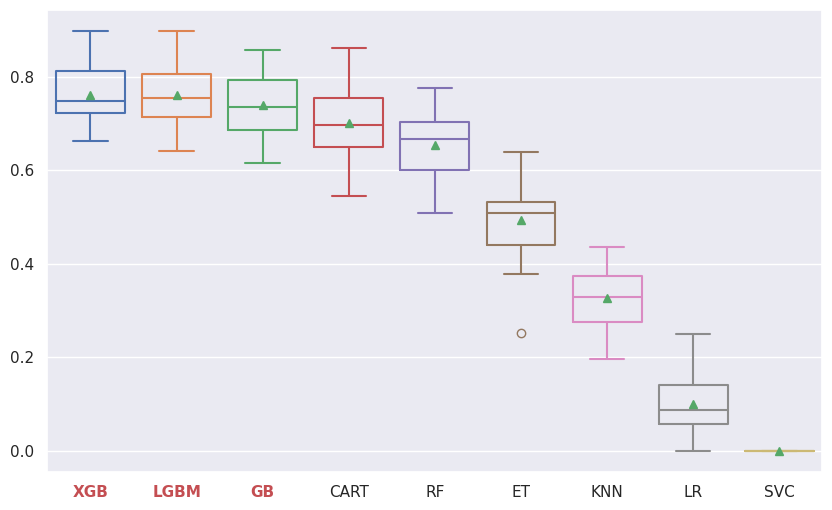

In [30]:
plot_kfold_result(
    names=names, results=results
)

# 2. Scaling

<b>Standardization</b>

<b>Power transformation</b>

# 3.1 Feature Selection without "PCA"

<b>Sequential feature selection</b>

<b>RFE</b>

# 3.2 Feature Selection with "PCA"

<b>Sequential feature selection</b>

<b>RFE</b>

# 4. Resampling

<b>Over sampling</b>

<b>Combine</b>